In [30]:
from fastai.vision.all import *
from fastai.vision.data import *
import os
import requests
import json
import glob

In [118]:
categories = ['dog', 'cat']
path = "02_images"

for category in categories:
    images = search_bing_images(category)
    download_bing_images(f'{path}/{category}', images)
    
failed_images = verify_images(get_image_files('02_images'))
for image in failed_images:
    Path(image).unlink()
    print(f'Removed {image} from archive')

Found 35 images for dog


KeyboardInterrupt: 

In [114]:
dls = DataBlock(blocks=(ImageBlock, CategoryBlock),
               get_items=get_image_files,
               get_y=get_label,
               splitter=RandomSplitter(valid_pct=0.2, seed=42),
               item_tfms=Resize(224))
dataset = dls.dataloaders('02_images', bs=5)

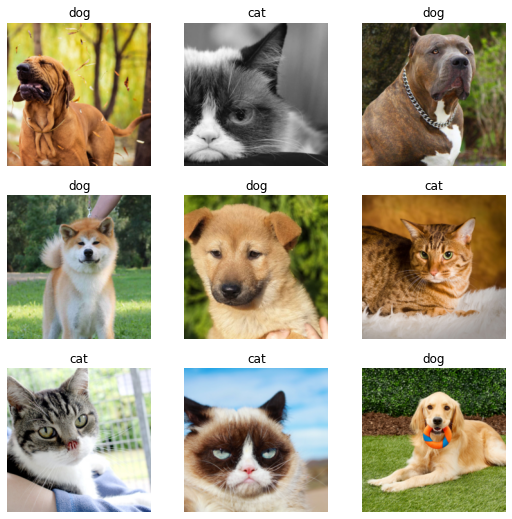

In [106]:
dataset.train.show_batch()

In [115]:
learn = cnn_learner(dataset, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.071816,0.125841,0.083333,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.532786,0.071295,0.083333,00:02
1,0.488099,0.008798,0.000000,00:02


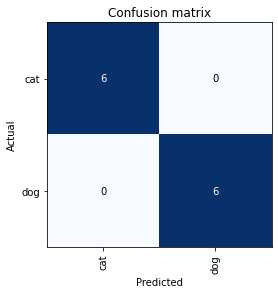

In [116]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [124]:
r = requests.get('https://ichef.bbci.co.uk/news/976/cpsprodpb/12A9B/production/_111434467_gettyimages-1143489763.jpg')
os.makedirs('02_images/test')
with open('02_images/test/test-cat.jpg', 'wb') as image:
    image.write(r.content)

In [125]:
learn.predict('02_images/test/test-cat.jpg')

('cat', tensor(0), tensor([9.9979e-01, 2.1133e-04]))

In [51]:
def get_label(path):
    return Path(path).parent.name

In [52]:
def get_image_files(path):
    return glob.glob(f'./{path}/**/*.jpg', recursive=True)

In [6]:
bing_key = os.environ.get("BING_KEY", "6f18f5ddbb6f45f4a49dee94e033977e") # Fuck it, it's being weird
if bing_key is None:
    raise ValueError("No Bing environment key found")

In [24]:
def search_bing_images(search_term):
    headers = {'Ocp-Apim-Subscription-Key': bing_key}
    endpoint = f'https://api.bing.microsoft.com/v7.0/images/search?q={search_term}'
    r = requests.get(endpoint, headers=headers)
    parsed = json.loads(r.text)
    image_urls = list(map(lambda el: el['contentUrl'], parsed['value']))
    print(f"Found {len(image_urls)} images for {search_term}")
    return image_urls

In [55]:
def download_bing_images(dest, image_url_list):
    dest = Path()/dest
    os.makedirs(dest, exist_ok=True)
    for index, url in enumerate(image_url_list):
        try: 
            r = requests.get(url, timeout=1)
        except requests.exceptions.Timeout:
            continue
        with open(dest/f'{index}.jpg', 'wb') as image:
            image.write(r.content)
    print(f"Finished downloading images into {dest}")